In [1]:
%cd ..

/home/akajal/DiVAE


In [2]:
# Python imports
import os
import sys

# Add the path to the parent directory to augment search for module
sys.path.append(os.getcwd())
# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if par_dir not in sys.path:
    sys.path.append(par_dir)
    
# ML imports
import torch
import matplotlib.pyplot as plt
import numpy as np

# DiVAE imports
from models.rbm.chimeraRBM import ChimeraRBM
from models.rbm.rbm import RBM
from models.samplers.pcd import PCD

from utils import *

# DWave imports
from dwave.system import DWaveSampler, LeapHybridSampler
import neal

[10:42:23.896] INFO   DiVAE                                             Willkommen!
[10:42:23.898] INFO   DiVAE                                             Loading configuration.
2022-02-19 10:42:26,136 dwave.cloud INFO  MainThread Log level for 'dwave.cloud' namespace set to 0
[10:42:26.136] INFO   dwave.cloud                                       Log level for 'dwave.cloud' namespace set to 0


In [31]:
def beta_estimation_ising(num_iterations=100, lr=0.01, beta_init=5., n_reads=1000, crbm_sampler=None, dwave_sampler=None):
    assert crbm_sampler is not None
    assert dwave_sampler is not None
    
    beta = beta_init
    betas = [beta]
    
    crbm = crbm_sampler.get_rbm()
    crbm_weights, crbm_vbias, crbm_hbias = crbm.weights, crbm.visible_bias, crbm.hidden_bias
    
    ising_weights = crbm_weights/4.
    ising_vbias = crbm_vbias/2. + torch.sum(crbm_weights, dim=0)/4.
    ising_hbias = crbm_hbias/2. + torch.sum(crbm_weights, dim=1)/4.
    
    n_vis = len(crbm.visible_qubit_idxs)
    qubit_idxs = crbm.visible_qubit_idxs+crbm.hidden_qubit_idxs
    
    visible_idx_map_inv = {i:visible_qubit_idx for i, visible_qubit_idx in enumerate(crbm.visible_qubit_idxs)}
    hidden_idx_map_inv = {i:hidden_qubit_idx for i, hidden_qubit_idx in enumerate(crbm.hidden_qubit_idxs)}
    
    for i in range(num_iterations):
        dwave_weights, dwave_vbias, dwave_hbias = ising_weights/beta, ising_vbias/beta, ising_hbias/beta
        dwave_weights_np = dwave_weights.detach().cpu().numpy()
        
        biases = torch.cat((dwave_vbias, dwave_hbias)).detach().cpu().numpy()
        h = {qubit_idx:bias for qubit_idx, bias in zip(qubit_idxs, biases)}
        J = {}
        for row in range(dwave_weights_np.shape[0]):
            for col in range(dwave_weights_np.shape[1]):
                if dwave_weights_np[row][col] != 0:
                    J[(visible_idx_map_inv[row], hidden_idx_map_inv[col])] = dwave_weights_np[row][col]
                    
        response = dwave_sampler.sample_ising(h, J, num_reads=n_reads)
        dwave_samples, dwave_energies = batch_dwave_samples(response)
        dwave_samples = torch.from_numpy(dwave_samples).float()
        dwave_vis, dwave_hid = dwave_samples[:, :n_vis], dwave_samples[:, n_vis:]
        
        dwave_energy_exp = sample_energies_exp(dwave_weights, dwave_vbias, dwave_hbias, dwave_vis, dwave_hid)
        dwave_energy_exp = torch.mean(dwave_energy_exp, axis=0)
        
        crbm_vis, crbm_hid = crbm_sampler.block_gibbs_sampling()
        
        zero = torch.tensor(0., dtype=torch.float)
        minus_one = torch.tensor(-1., dtype=torch.float)
        
        crbm_vis = torch.where(crbm_vis == zero, minus_one, crbm_vis)
        crbm_hid = torch.where(crbm_hid == zero, minus_one, crbm_hid)
        
        crbm_energy_exp = sample_energies_exp(dwave_weights, dwave_vbias, dwave_hbias, crbm_vis, crbm_hid)
        crbm_energy_exp = torch.mean(crbm_energy_exp, axis=0)
        
        beta = beta + lr*(float(crbm_energy_exp) - float(dwave_energy_exp))
        betas.append(beta)
        
    return betas

In [32]:
_NUM_NODES = 16
crbm_1 = ChimeraRBM(n_visible=_NUM_NODES, n_hidden=_NUM_NODES)
crbm_sampler_1 = PCD(batch_size=1024, RBM=crbm_1, n_gibbs_sampling_steps=100)

sa_sampler = neal.SimulatedAnnealingSampler()

In [33]:
betas = beta_estimation_ising(num_iterations=100, lr=0.01, beta_init=5., n_reads=1024, crbm_sampler=crbm_sampler_1, dwave_sampler=sa_sampler)

In [34]:
def plot_betas(betas):
    """
    Plot the estimates of beta during the beta estimation procedure   
    """
    fig, ax = plt.subplots(figsize=(40, 16))
    
    plt.plot(np.arange(len(betas)), betas)
    
    ax.set_xlabel("Iteration", fontsize=60)
    ax.set_ylabel("Beta", fontsize=60)
    
    ax.tick_params(axis='both', which='major', labelsize=60)
    ax.grid(True)
    
    plt.show()
    plt.close()

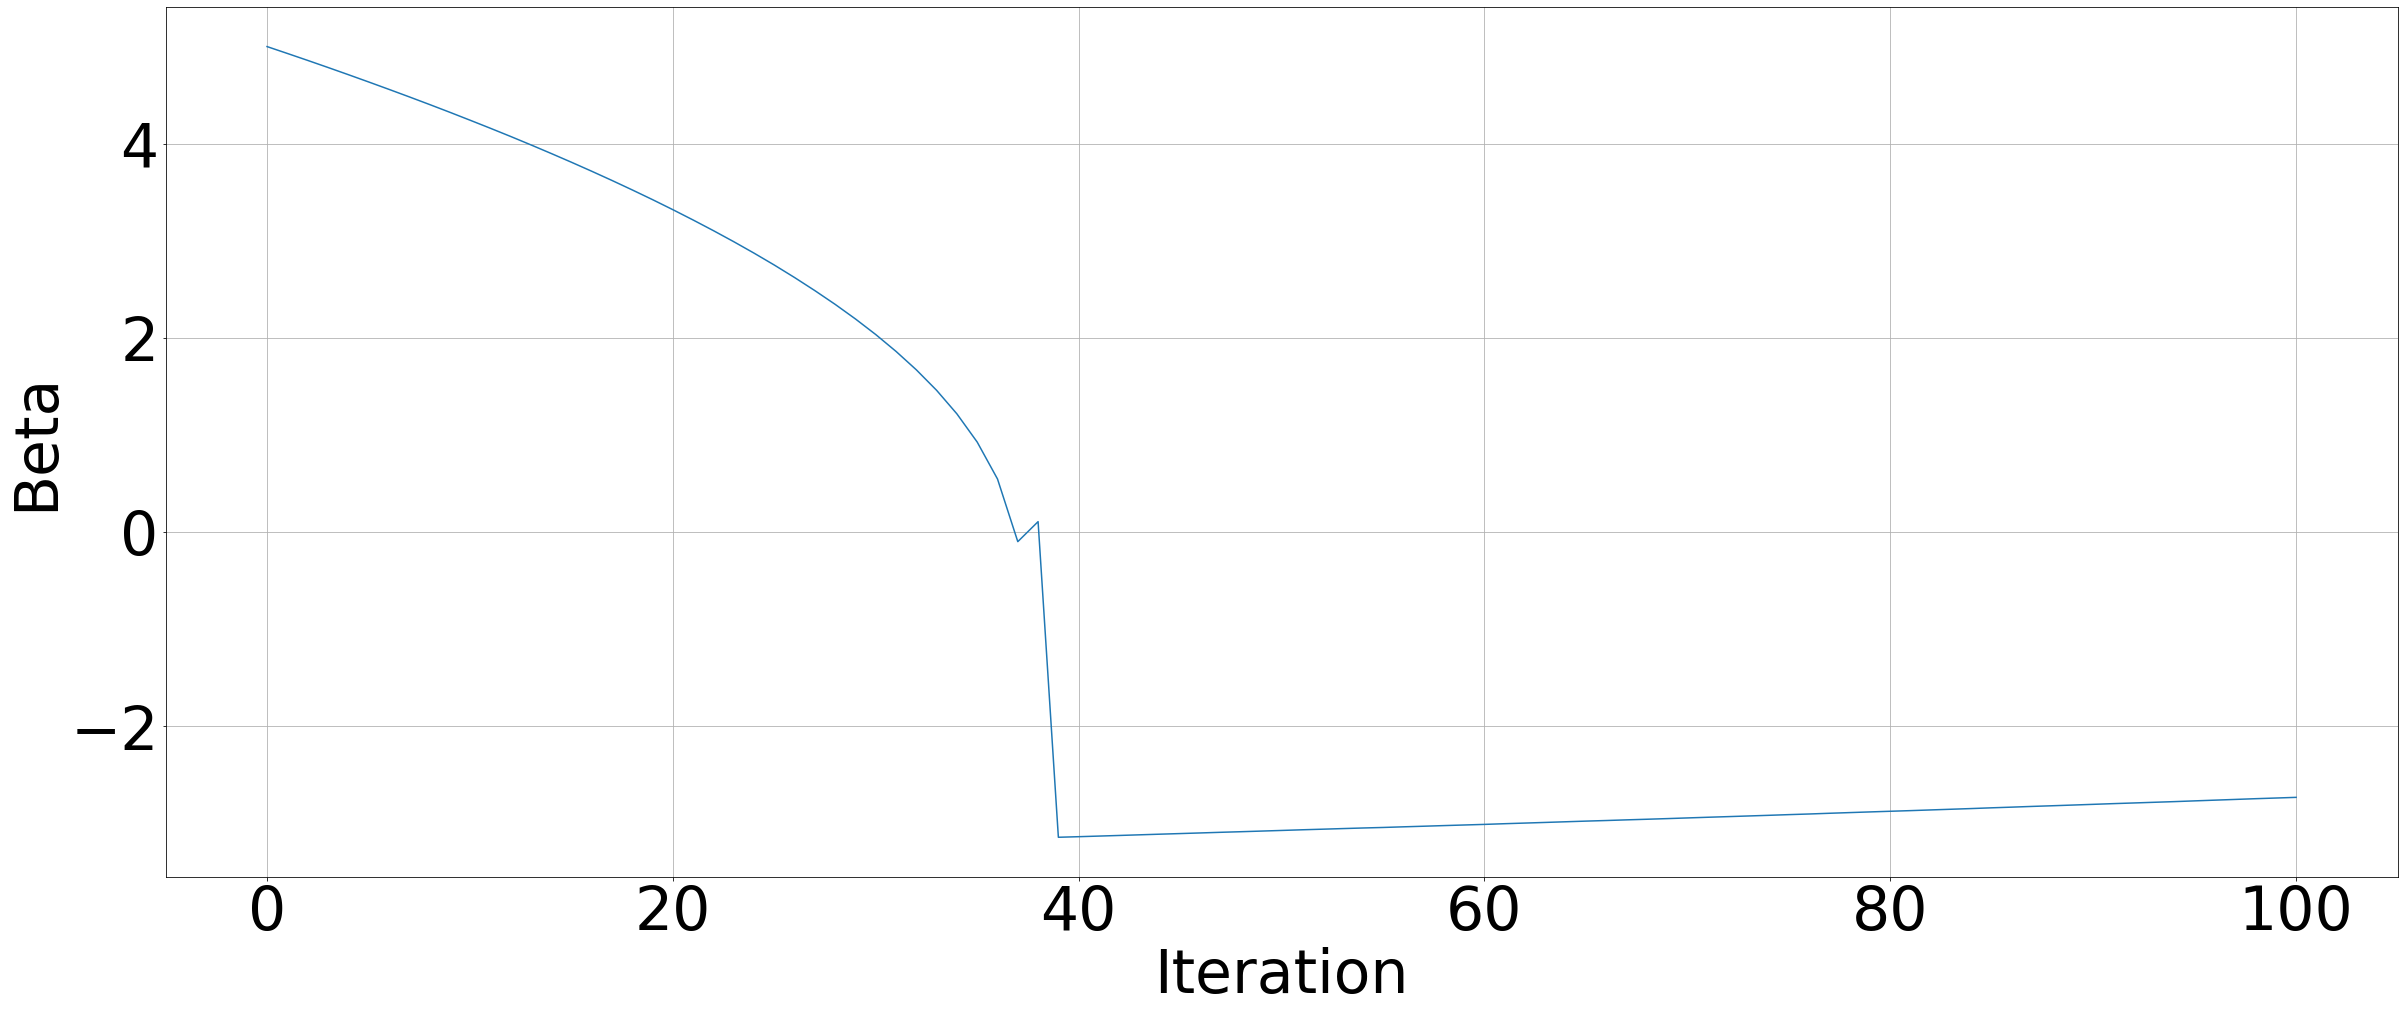

In [35]:
plot_betas(betas)

In [36]:
def beta_estimation_ising_classical(num_iterations=100, lr=0.01, beta_init=5.,crbm_sampler_1=None, crbm_sampler_2=None):
    assert crbm_sampler_1 is not None and crbm_sampler_2 is not None
    
    beta = beta_init
    betas = [beta]
    
    crbm = crbm_sampler_1.get_rbm()
    crbm_weights, crbm_vbias, crbm_hbias = crbm.weights, crbm.visible_bias, crbm.hidden_bias
    
    ising_weights = crbm_weights/4.
    ising_vbias = crbm_vbias/2. + torch.sum(crbm_weights, dim=0)/4.
    ising_hbias = crbm_hbias/2. + torch.sum(crbm_weights, dim=1)/4.
    
    crbm_2 = crbm_sampler_2.get_rbm()
    
    for i in range(num_iterations):
        crbm_2._weights = torch.nn.Parameter(ising_weights/beta)
        crbm_2._visible_bias = torch.nn.Parameter(ising_vbias/beta)
        crbm_2._hidden_bias = torch.nn.Parameter(ising_hbias/beta)
        
        zero = torch.tensor(0., dtype=torch.float)
        minus_one = torch.tensor(-1., dtype=torch.float)
        
        crbm_vis_1, crbm_hid_1 = crbm_sampler_1.block_gibbs_sampling()
        crbm_vis_1 = torch.where(crbm_vis_1 == zero, minus_one, crbm_vis_1)
        crbm_hid_1 = torch.where(crbm_hid_1 == zero, minus_one, crbm_hid_1)
        
        crbm_energy_exp_1 = sample_energies_exp(crbm_2._weights, crbm_2._visible_bias, crbm_2._hidden_bias,
                                                crbm_vis_1, crbm_hid_1)
        crbm_energy_exp_1 = torch.mean(crbm_energy_exp_1, axis=0)
        
        crbm_vis_2, crbm_hid_2 = crbm_sampler_2.block_gibbs_sampling()
        crbm_vis_2 = torch.where(crbm_vis_2 == zero, minus_one, crbm_vis_2)
        crbm_hid_2 = torch.where(crbm_hid_2 == zero, minus_one, crbm_hid_2)
        
        crbm_energy_exp_2 = sample_energies_exp(crbm_2._weights, crbm_2._visible_bias, crbm_2._hidden_bias,
                                                crbm_vis_2, crbm_hid_2)
        crbm_energy_exp_2 = torch.mean(crbm_energy_exp_2, axis=0)
        
        beta = beta + lr*(float(crbm_energy_exp_1) - float(crbm_energy_exp_2))
        betas.append(beta)
        
    return betas

In [37]:
_NUM_NODES = 16
crbm_1 = ChimeraRBM(n_visible=_NUM_NODES, n_hidden=_NUM_NODES)
crbm_sampler_1 = PCD(batch_size=1024, RBM=crbm_1, n_gibbs_sampling_steps=100)

crbm_2 = ChimeraRBM(n_visible=_NUM_NODES, n_hidden=_NUM_NODES)
crbm_sampler_2 = PCD(batch_size=1024, RBM=crbm_2, n_gibbs_sampling_steps=100)

In [40]:
betas = beta_estimation_ising_classical(num_iterations=100, lr=0.1, beta_init=2.,crbm_sampler_1=crbm_sampler_1, crbm_sampler_2=crbm_sampler_2)

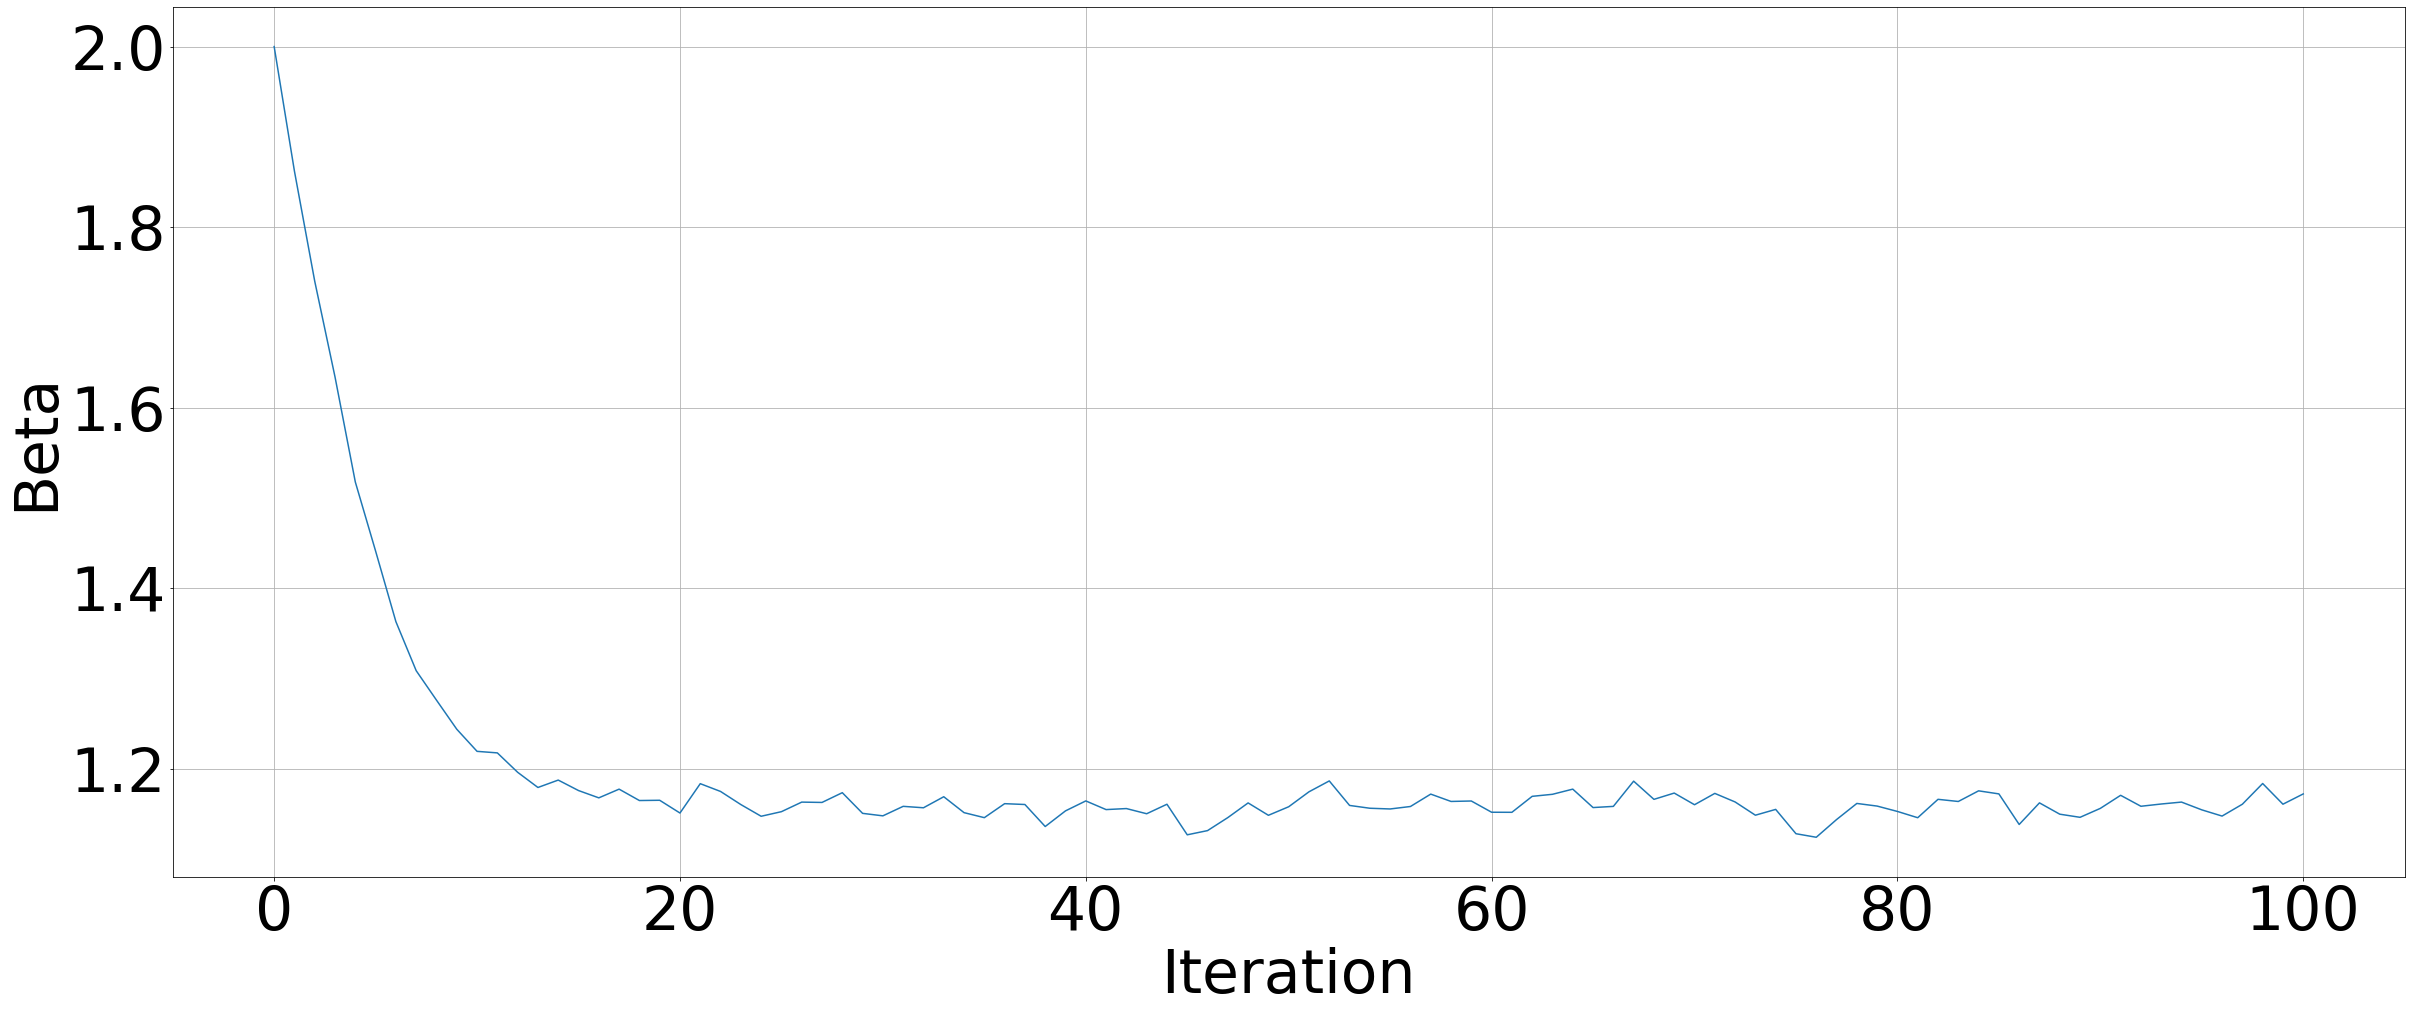

In [41]:
plot_betas(betas)

In [42]:
_NUM_NODES = 16
crbm = ChimeraRBM(n_visible=_NUM_NODES, n_hidden=_NUM_NODES)
crbm_sampler = PCD(batch_size=1024, RBM=crbm, n_gibbs_sampling_steps=100)

qpu_sampler = DWaveSampler(solver={"topology__type":"chimera"})

2022-02-19 12:22:29,713 dwave.cloud.client.base INFO  MainThread Fetching available regions from the Metadata API at 'https://cloud.dwavesys.com/metadata/v1/'
[12:22:29.713] INFO   dwave.cloud.client.base                           Fetching available regions from the Metadata API at 'https://cloud.dwavesys.com/metadata/v1/'
2022-02-19 12:22:30,099 dwave.cloud.client.base INFO  MainThread Fetching definitions of all available solvers
[12:22:30.099] INFO   dwave.cloud.client.base                           Fetching definitions of all available solvers
2022-02-19 12:22:30,923 dwave.cloud.client.base INFO  MainThread Adding solver StructuredSolver(id='DW_2000Q_6')
[12:22:30.923] INFO   dwave.cloud.client.base                           Adding solver StructuredSolver(id='DW_2000Q_6')
2022-02-19 12:22:31,042 dwave.cloud.client.base INFO  MainThread Adding solver StructuredSolver(id='Advantage_system4.1')
[12:22:31.042] INFO   dwave.cloud.client.base                           Adding solver Struc

In [43]:
betas = beta_estimation_ising(num_iterations=100, lr=0.1, beta_init=2., n_reads=1024, crbm_sampler=crbm_sampler, dwave_sampler=qpu_sampler)

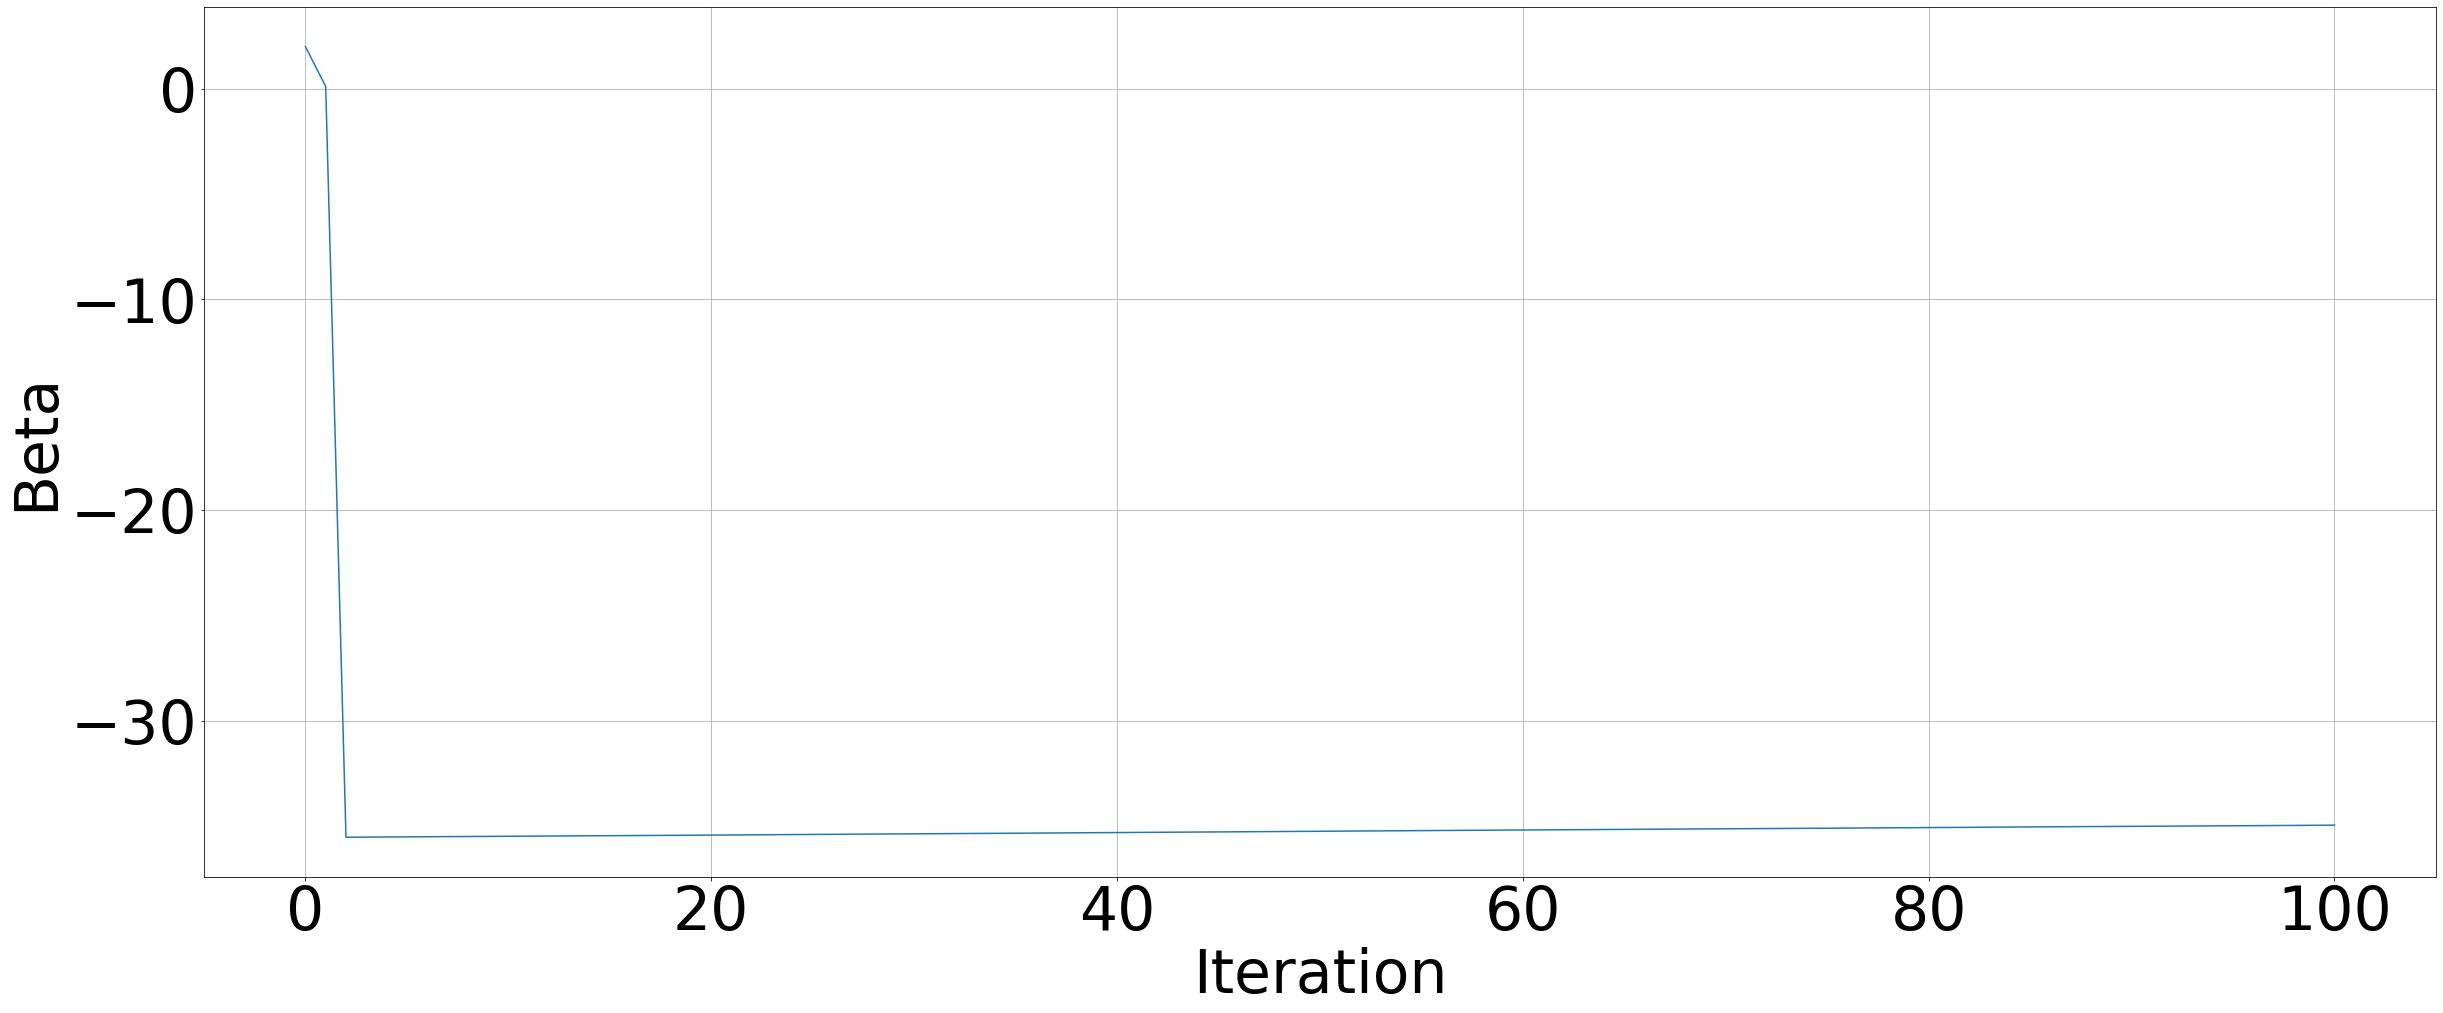

In [44]:
plot_betas(betas)

In [47]:
betas = beta_estimation_ising(num_iterations=10, lr=0.1, beta_init=5., n_reads=100, crbm_sampler=crbm_sampler, dwave_sampler=qpu_sampler)

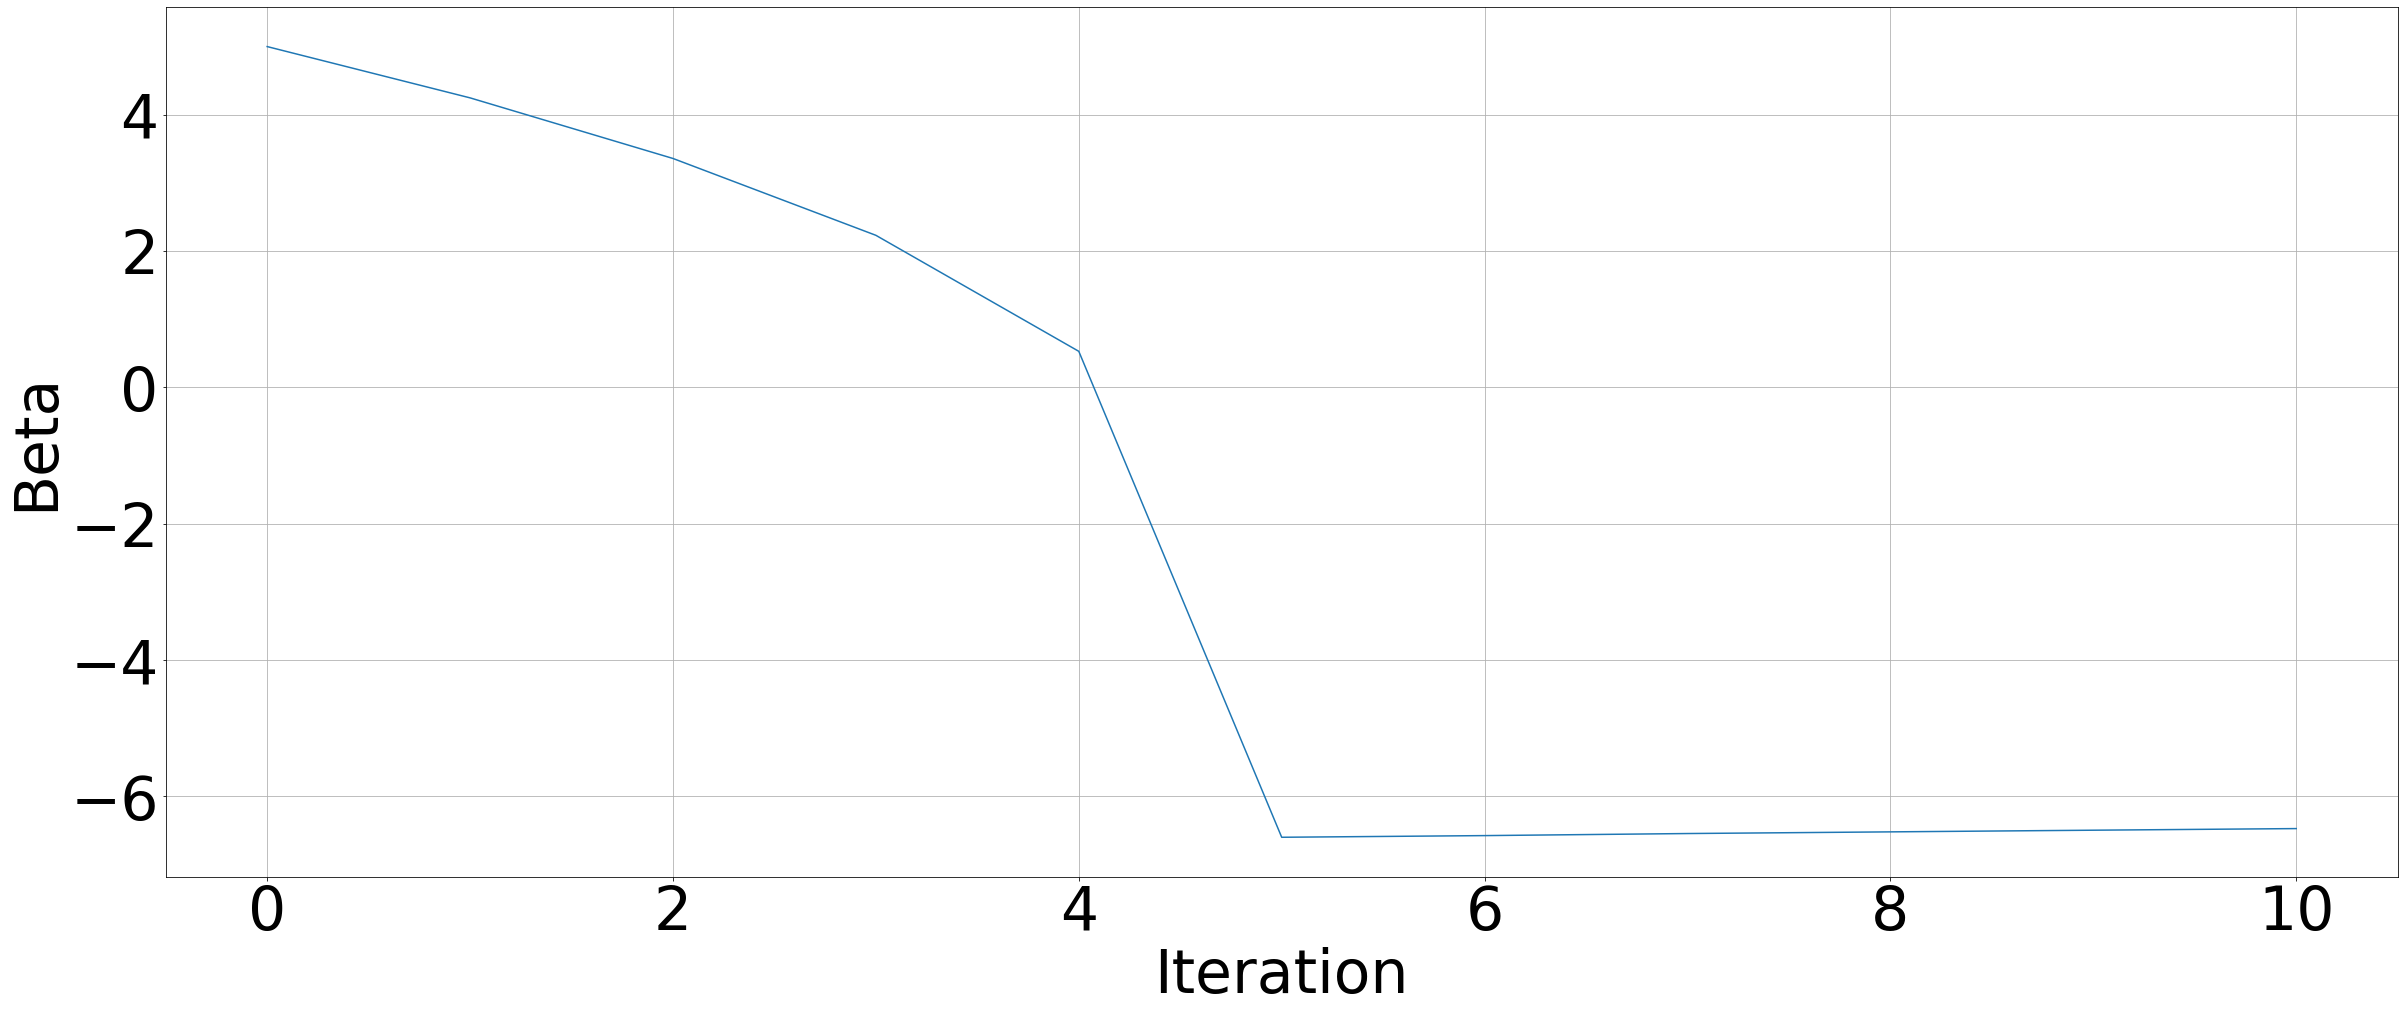

In [48]:
plot_betas(betas)

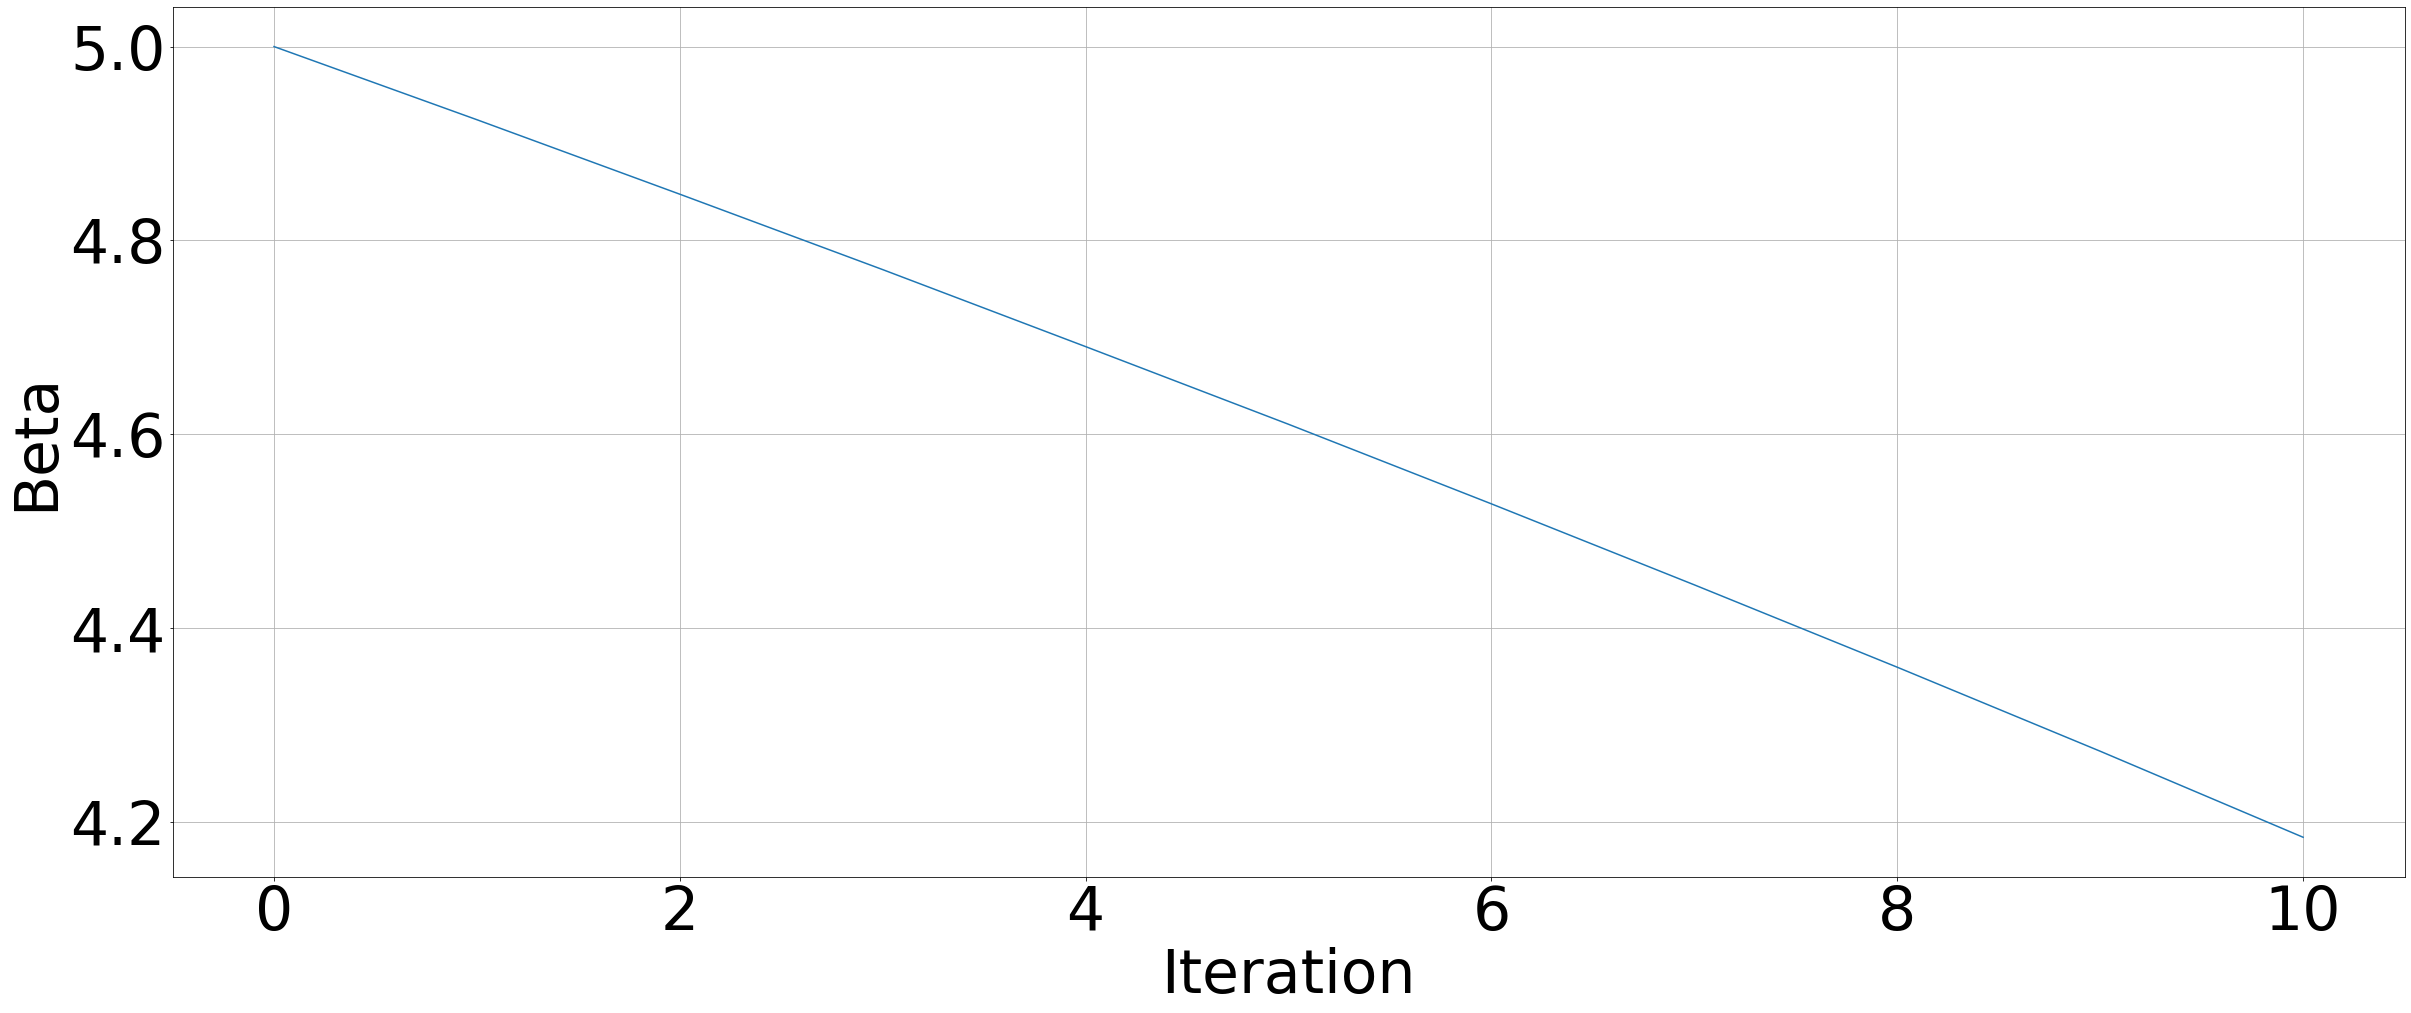

In [49]:
betas = beta_estimation_ising(num_iterations=10, lr=0.01, beta_init=5., n_reads=100, crbm_sampler=crbm_sampler, dwave_sampler=qpu_sampler)
plot_betas(betas)